# Data Analysis Notebook

This data analysis notebook is a collection of common methods shown using static analysis and visualizations.  
Datasets can be swapped out and all contained in the datasets folder are intended to work with this notebook.  

### Library imports

These are library imports which the notebook will use throughout, this should be executed first.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from itertools import combinations

### Load Data

We select a dataset from the datasets folder and view what the dataframe looks like for 5 rows.

In [2]:
# specify the folder where the datasets are stored
datasets_folder = 'datasets/'

# Specify the file path to the CSV file containing the data
file_path = datasets_folder + 'fisher_iris.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

### Data Characteristics

This displays information of the dataset.

- Case count
- Class count
- Class names
- Cases per class
- Attribute count
- Attribute names
- 5 data rows

In [3]:
# Get the unique class names
class_names = df['class'].unique()
class_names = [name.lower() for name in class_names]

# Get the column names of the DataFrame
columns = df.columns

# remove the 'class' column
columns = columns.drop('class')

n_features = len(columns)

# Set the color map based on the number of classes in the 'class' column
class_names = [name.lower() for name in class_names]
class_count = len(class_names)

# Display DataFrame information
print('Number of cases: ', df.shape[0])
print('Number of classes: ', len(df['class'].unique()))

print('Classes: ', df['class'].unique())
print(df['class'].value_counts(), sep='\n')

# -1 for the class column
print('Number of attributes: ', df.shape[1] - 1)
print('Attributes: ', df.columns.drop('class').values)

# Display the top 5 rows of the DataFrame
df.head()

Number of cases:  150
Number of classes:  3
Classes:  ['Setosa' 'Versicolor' 'Virginica']
class
Setosa        50
Versicolor    50
Virginica     50
Name: count, dtype: int64
Number of attributes:  4
Attributes:  ['sepal.length' 'sepal.width' 'petal.length' 'petal.width']


,sepal.length,sepal.width,petal.length,petal.width,class
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


### Data Normalization

First we *normalize* the dataframe for all numerical values. For this process we utilize min-max normalzation formula.  
Data normalization simplifies computation, minimizes error, and simplifies analysis by standardizing the data format.  

(Non-numerical attributes may be mapped to enumerated values $[0,1]$, however, this is a delicate issue we will not cover.)  

min-max normalization formula:

Normalized value $\hat{x} = \frac{x - \min x}{\max x - \min x}$ this is an application of vector normalization with consideration of minimum not being strictly zero.  

where $\min x$ is the minimum and $\max x$ is the maximum of an attribute column, and $x$ is the value to be normalized in the same column.


In [4]:
# Function to display ranges
def display_ranges(df, class_column='class'):
    print("Ranges for each attribute for each class:")
    classes = df[class_column].unique()
    for class_name in classes:
        print(f"\nClass: {class_name}")
        class_subset = df[df[class_column] == class_name]
        for column in df.columns.drop(class_column):
            min_val = class_subset[column].min()
            max_val = class_subset[column].max()
            print(f"{column}: Min = {min_val:.2f}, Max = {max_val:.2f}")

# Display ranges before normalization
print("Before Normalization")
display_ranges(df)

# Create a new DataFrame with the data
df_normalized = df.copy()
columns = df.columns.drop('class')

# Min-max normalization of new DataFrame
df_normalized[columns] = (df[columns] - df[columns].min()) / (df[columns].max() - df[columns].min())


# Display ranges after normalization
print("\nAfter Normalization")
display_ranges(df_normalized)

Before Normalization
Ranges for each attribute for each class:

Class: Setosa
sepal.length: Min = 4.30, Max = 5.80
sepal.width: Min = 2.30, Max = 4.40
petal.length: Min = 1.00, Max = 1.90
petal.width: Min = 0.10, Max = 0.60

Class: Versicolor
sepal.length: Min = 4.90, Max = 7.00
sepal.width: Min = 2.00, Max = 3.40
petal.length: Min = 3.00, Max = 5.10
petal.width: Min = 1.00, Max = 1.80

Class: Virginica
sepal.length: Min = 4.90, Max = 7.90
sepal.width: Min = 2.20, Max = 3.80
petal.length: Min = 4.50, Max = 6.90
petal.width: Min = 1.40, Max = 2.50

After Normalization
Ranges for each attribute for each class:

Class: Setosa
sepal.length: Min = 0.00, Max = 0.42
sepal.width: Min = 0.12, Max = 1.00
petal.length: Min = 0.00, Max = 0.15
petal.width: Min = 0.00, Max = 0.21

Class: Versicolor
sepal.length: Min = 0.17, Max = 0.75
sepal.width: Min = 0.00, Max = 0.58
petal.length: Min = 0.34, Max = 0.69
petal.width: Min = 0.38, Max = 0.71

Class: Virginica
sepal.length: Min = 0.17, Max = 1.00
sep

### Pure subinterval search

In [27]:
# Define the function to find the overall intervals for each class
def find_overall_intervals(df, class_names):
    overall_intervals = {}
    for class_name in class_names:
        overall_intervals[class_name] = {}
        for feature in df.columns.drop('class'):
            class_subset = df[df['class'] == class_name][feature]
            min_val, max_val = class_subset.min(), class_subset.max()
            overall_intervals[class_name][feature] = [(min_val, max_val)]
    return overall_intervals

# Define the function to subtract intervals
def subtract_intervals(intervals, subtract_intervals):
    result = []
    for (start, end) in intervals:
        temp_intervals = [(start, end)]
        for (sub_start, sub_end) in subtract_intervals:
            new_intervals = []
            for (temp_start, temp_end) in temp_intervals:
                if sub_start <= temp_start and sub_end >= temp_end:
                    continue
                elif sub_start <= temp_start < sub_end < temp_end:
                    temp_start = sub_end
                elif temp_start < sub_start < temp_end <= sub_end:
                    temp_end = sub_start
                elif temp_start < sub_start and temp_end > sub_end:
                    new_intervals.append((temp_start, sub_start))
                    temp_start = sub_end
                new_intervals.append((temp_start, temp_end))
            temp_intervals = new_intervals
        result.extend(temp_intervals)
    return result

# Define the function to find pure intervals by subtracting overlapping intervals
def find_pure_intervals(df, overall_intervals, class_names):
    pure_intervals = {}
    for class_name in class_names:
        pure_intervals[class_name] = {}
        for feature in df.columns.drop('class'):
            intervals = overall_intervals[class_name][feature]
            for other_class in class_names:
                if other_class != class_name:
                    other_intervals = overall_intervals[other_class][feature]
                    intervals = subtract_intervals(intervals, other_intervals)
            pure_intervals[class_name][feature] = intervals
    return pure_intervals

# Define the function to validate intervals
def validate_intervals(df, pure_intervals):
    validation_results = {}
    for class_name, features in pure_intervals.items():
        validation_results[class_name] = {}
        for feature, intervals in features.items():
            validation_results[class_name][feature] = []
            for min_val, max_val in intervals:
                subset = df[(df[feature] >= min_val) & (df[feature] <= max_val)]
                unique_classes = subset['class'].unique()
                class_counts = subset['class'].value_counts().to_dict()
                is_pure = len(unique_classes) == 1 and unique_classes[0] == class_name.lower()
                validation_results[class_name][feature].append({
                    'range': (min_val, max_val),
                    'is_pure': is_pure,
                    'cases': len(subset),
                    'class_counts': class_counts,
                    'unique_classes': unique_classes
                })
    return validation_results

# Get class names
class_names = df['class'].unique()

# Find overall intervals
overall_intervals = find_overall_intervals(df_normalized, class_names)

# Find pure intervals
pure_intervals = find_pure_intervals(df_normalized, overall_intervals, class_names)

# Validate intervals
validation_results = validate_intervals(df_normalized, pure_intervals)

# Print the pure intervals
print("Pure Intervals:")
for class_name, features in pure_intervals.items():
    print(f"\nClass: {class_name}")
    for feature, intervals in features.items():
        print(f"  {feature}: {intervals}")

# Print the validation results
print("\nValidation Results:")
for class_name, features in validation_results.items():
    print(f"\nClass: {class_name}")
    for feature, results in features.items():
        for result in results:
            print(f"  {feature}: {result['range']}, Pure: {result['is_pure']}, Cases: {result['cases']}, Class Counts: {result['class_counts']}, Unique Classes: {result['unique_classes']}")

Pure Intervals:

Class: Setosa
  sepal.length: [(0.0, 0.1666666666666668)]
  sepal.width: [(0.7499999999999998, 1.0)]
  petal.length: [(0.0, 0.15254237288135591)]
  petal.width: [(0.0, 0.20833333333333334)]

Class: Versicolor
  sepal.length: []
  sepal.width: [(0.0, 0.0833333333333334)]
  petal.length: [(0.3389830508474576, 0.5932203389830508)]
  petal.width: [(0.375, 0.5416666666666666)]

Class: Virginica
  sepal.length: [(0.7499999999999999, 1.0)]
  sepal.width: []
  petal.length: [(0.6949152542372881, 1.0)]
  petal.width: [(0.7083333333333334, 1.0)]

Validation Results:

Class: Setosa
  sepal.length: (0.0, 0.1666666666666668), Pure: False, Cases: 22, Class Counts: {'Setosa': 20, 'Versicolor': 1, 'Virginica': 1}, Unique Classes: ['Setosa' 'Versicolor' 'Virginica']
  sepal.width: (0.7499999999999998, 1.0), Pure: False, Cases: 12, Class Counts: {'Setosa': 10, 'Virginica': 2}, Unique Classes: ['Setosa' 'Virginica']
  petal.length: (0.0, 0.15254237288135591), Pure: False, Cases: 50, Clas

### Notebook configuration

This sets up connsistently used figure size and alpha transparency values, and a colormap defined from the classes of the dataset.

Colormap:

- If the decision is two-class: green, red  
- If the decision is three-class: red, green, blue  
- Othewise 'Viridis' color palette with class number of colors.  


In [6]:
fsize = (10, 6)  # figure size
a = 0.4          # transparency

# Binary classification
if len(class_names) == 2:
        cmap = sns.color_palette(['green', 'red'])

# Three-class classification
elif len(class_names) == 3:
    cmap = sns.color_palette(['red', 'green', 'blue'])

# Multi-class classification
else:
    cmap = sns.color_palette('viridis', len(class_names))


### Pair plot

A pairplot or scatterplot matrix visualizes the relations between each pair of attributes in the dataset. With distribution plots down the main diagonal of the matrix visualization.

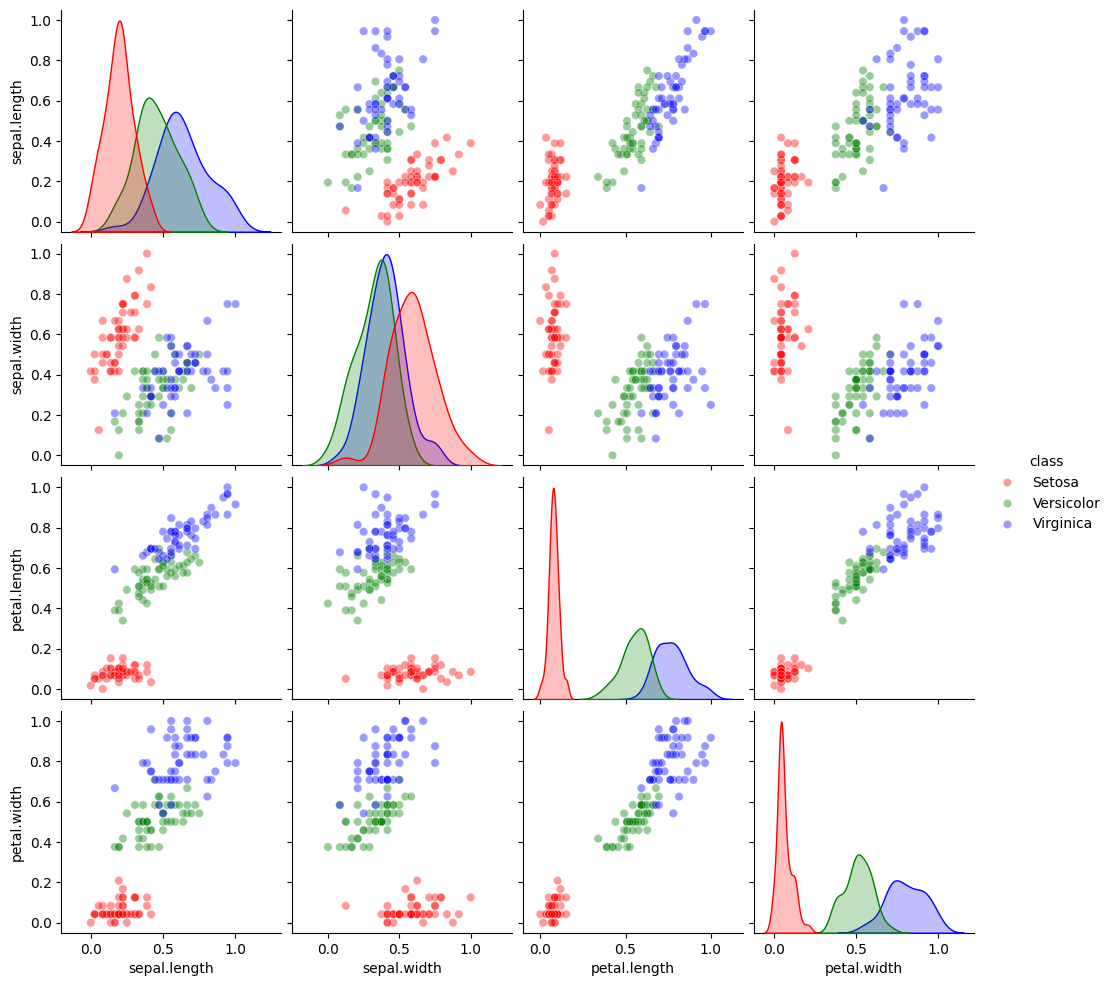

In [7]:
# Create a pairplot of the DataFrame
sns.pairplot(df_normalized, hue='class', vars=columns, palette=cmap, plot_kws={'alpha': a})

## Lossless Visualizations

Lossless visualization techniques allow for full multi-dimensional data distribution analysis. The following visualizations have this quality. These are the most standard of such visualizations.

### Parallel coordinates

We plot the data in a lossless General Line Coordinate method called Parallel coordinates showing all attributes and values.

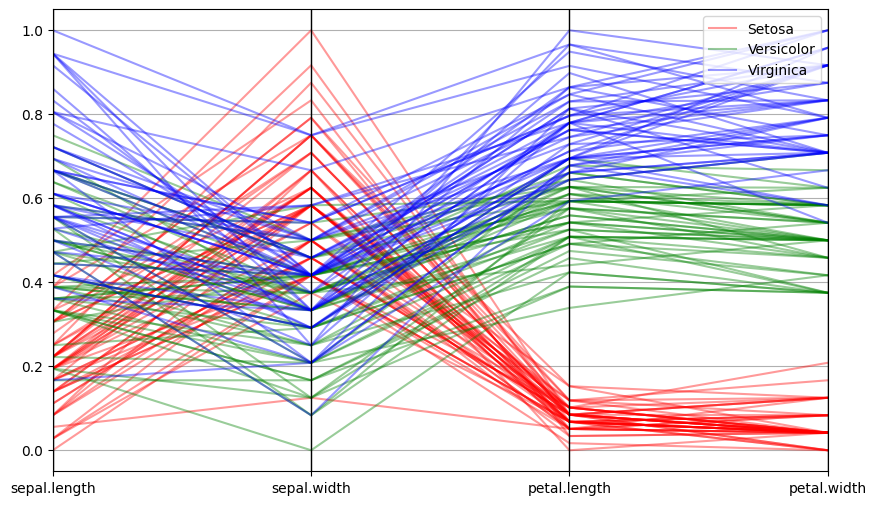

In [8]:
# set size
plt.figure(figsize=fsize)

# Plot the DataFrame in normalized parallel coordinates
pd.plotting.parallel_coordinates(df_normalized, 'class', color=cmap, alpha=a)

# Display the plot
plt.show()

### Parallel coordinates with convex hulls

Visualizaed are the envelopes, convex hulls, or hyperblocks of the above parallel coordinates visualization. These are regions which represent the associated class. We plot the most dense region through the center of each hull.

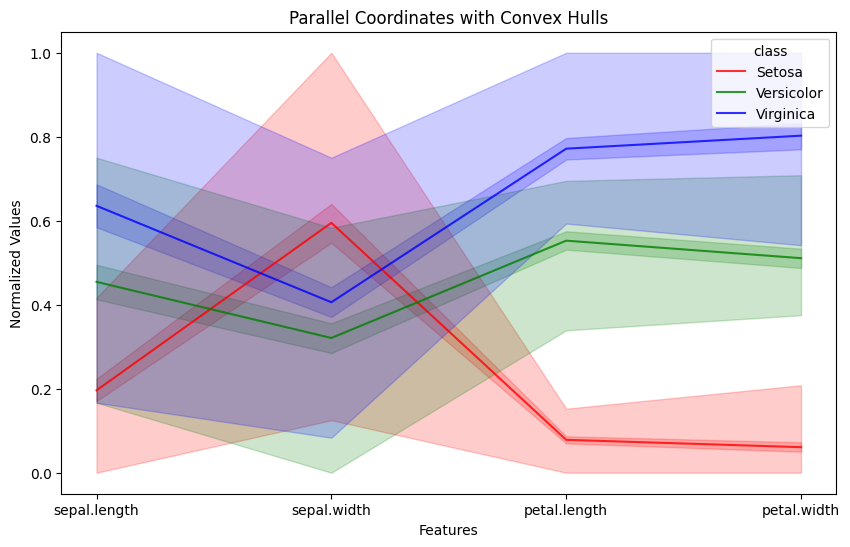

In [9]:
# Melt the DataFrame for seaborn
df_melted = df_normalized.melt(id_vars='class', var_name='Features', value_name='Normalized Values')

# Set the size of the plot
plt.figure(figsize=fsize)

# Plot the parallel coordinates
sns.lineplot(data=df_melted, x='Features', y='Normalized Values', hue='class', palette=cmap, alpha=0.8)

# Calculate and plot class boundaries
for class_name in df_normalized['class'].unique():
    subset = df_normalized[df_normalized['class'] == class_name].drop(columns='class')
    min_values = subset.min()
    max_values = subset.max()
    
    # Plot the fill between the min and max values
    plt.fill_between(min_values.index, min_values, max_values, color=cmap[class_names.index(class_name.lower())], alpha=0.2)

# Add title and labels
plt.title("Parallel Coordinates with Convex Hulls")
plt.xlabel("Features")
plt.ylabel("Normalized Values")

# Show the plot
plt.show()

### Andrew's Curves

A smoothed variant of Parallel coordinates using a finite Fourier series to produce smooth curves.

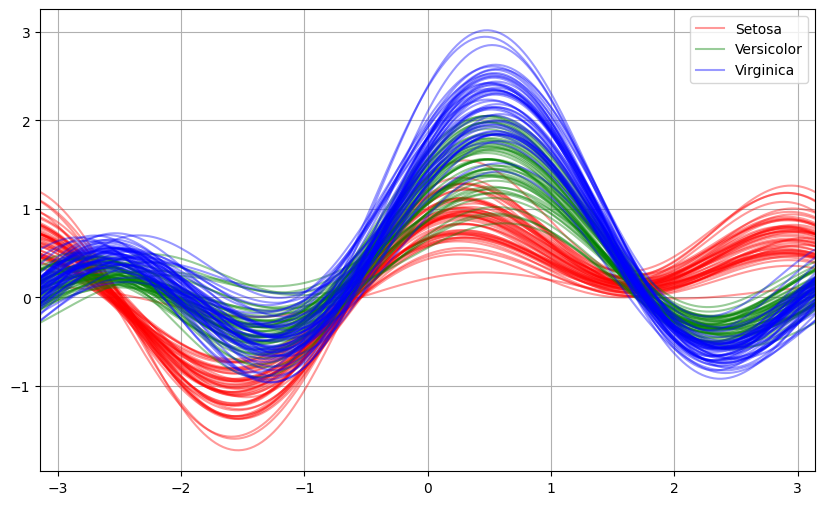

In [10]:
# set size
plt.figure(figsize=fsize)

# Plot the normalized DataFrame using Andrews Curves
pd.plotting.andrews_curves(df_normalized, 'class', color=cmap, alpha=a)

# Display the plot
plt.show()

### Star Plot

<Figure size 1000x600 with 0 Axes>

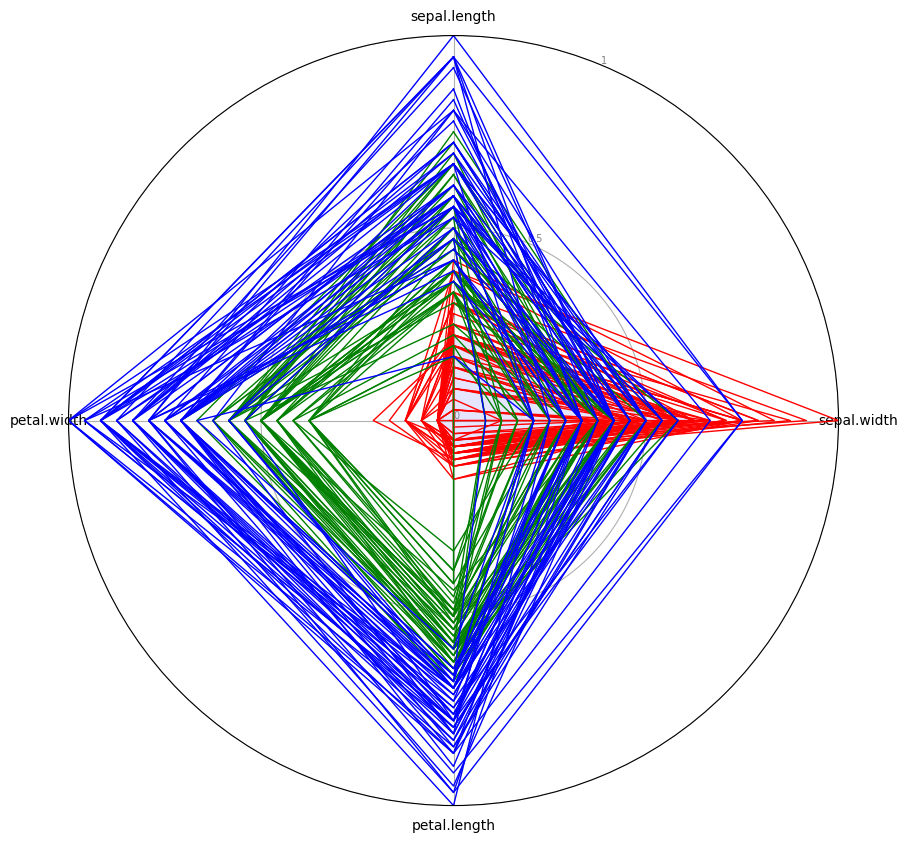

In [11]:
plt.figure(figsize=fsize)

# Convert DataFrame to numeric values
df_numeric = df_normalized.drop(columns=['class']).apply(pd.to_numeric, errors='coerce')

# Define radar chart parameters
labels = df_numeric.columns
num_vars = len(labels)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Add the first axis at the end

# The plot is circular, so we need to "complete the loop" and append the start at the end.
stats = df_numeric.values.tolist()

# Create radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable and add labels (excluding 'class')
plt.xticks(angles[:-1], labels)

# Draw y-labels
plt.yticks([0, 0.5, 1], ["0", "0.5", "1"], color="grey", size=7)
plt.ylim(0, 1)

# Get unique class labels
class_labels = df['class'].unique()

# Define a color map based on class labels
class_colors = {label: color for label, color in zip(class_labels, cmap)}

# Plot data
for i, (stat, label) in enumerate(zip(stats, df['class'])):
    stat += [stat[0]]  # Append the first element to complete the loop
    color = class_colors[label]  # Get color based on class label
    ax.plot(angles, stat, linewidth=1, linestyle='solid', color=color)

# Fill area
ax.fill(angles, stats[0], color='blue', alpha=0.1)

plt.show()

## Lossy Visualizations

### RadViz

RadViz or Radial Visualization

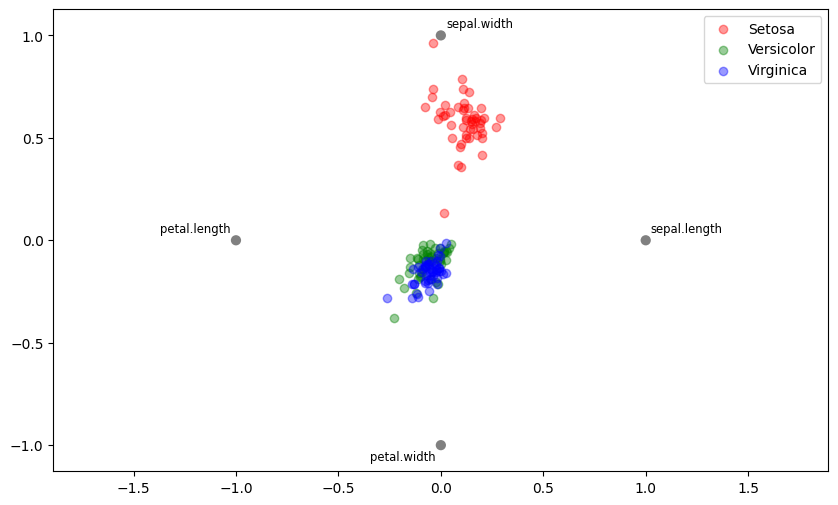

In [12]:
# set size
plt.figure(figsize=fsize)

# Create a Radviz plot of the DataFrame
pd.plotting.radviz(df_normalized, 'class', color=cmap, alpha=a)

# Display the plot
plt.show()

### T-SNE

T-Distributed Stochastic Neighbor Embedding

<Axes: xlabel='x', ylabel='y'>

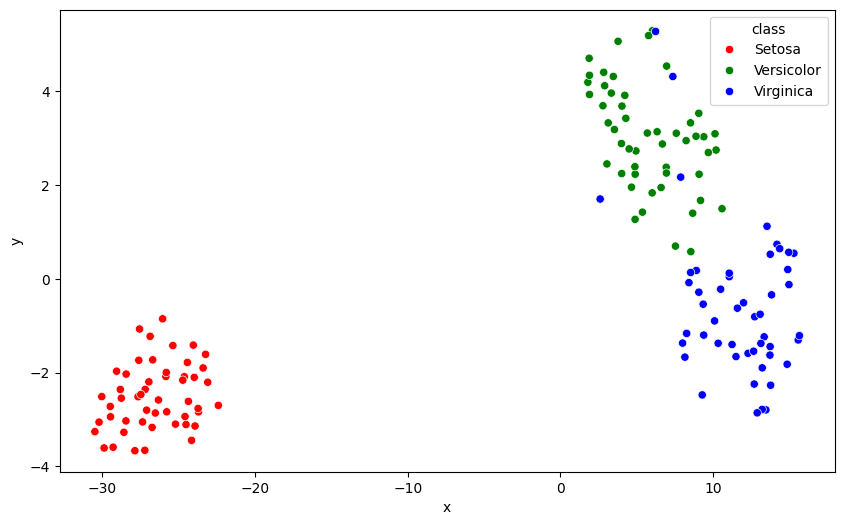

In [13]:
# Create a TSNE object
tsne = TSNE(n_components=2, random_state=0)

# Fit and transform the data
X_2d = tsne.fit_transform(df_normalized[columns])

# Create a DataFrame with the 2D data
df_2d = pd.DataFrame(X_2d, columns=['x', 'y'])

# Add the 'class' column to the DataFrame
df_2d['class'] = df['class']

# set size
plt.figure(figsize=fsize)

# Create a scatter plot of the 2D data
sns.scatterplot(x='x', y='y', hue='class', data=df_2d, palette=cmap)


### PCA

Principal Component Analysis

<Axes: xlabel='x', ylabel='y'>

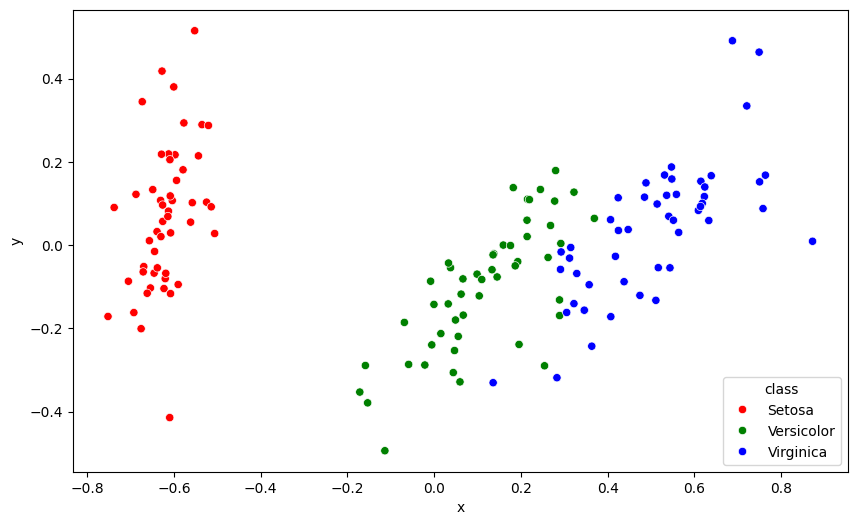

In [14]:
# Create a PCA object
pca = PCA(n_components=2)

# Fit and transform the data
X_2d = pca.fit_transform(df_normalized[columns])

# Create a DataFrame with the 2D data
df_2d = pd.DataFrame(X_2d, columns=['x', 'y'])

# Add the 'class' column to the DataFrame
df_2d['class'] = df['class']

# set size
plt.figure(figsize=fsize)

# Create a scatter plot of the 2D data
sns.scatterplot(x='x', y='y', hue='class', data=df_2d, palette=cmap)

## Classification Methods

### LDA

Linear Discriminant Analysis

Accuracy: 97.78%


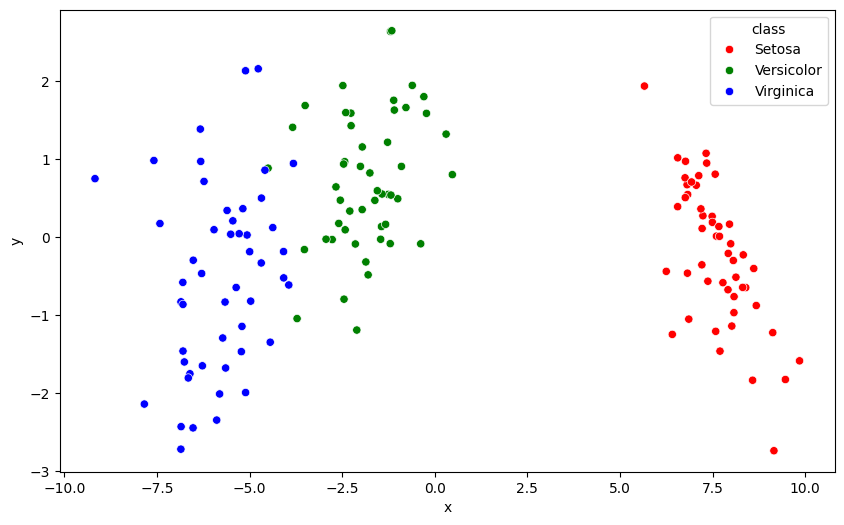

In [15]:
if 2 > min(n_features, class_count - 1):
    print('Number of components must be less than the minimum of n_features and n_classes - 1')
else:
    # Create a LinearDiscriminantAnalysis object
    lda = LinearDiscriminantAnalysis(n_components=2)

    # Fit and transform the data
    X_2d = lda.fit_transform(df_normalized[columns], df['class'])

    # Create a DataFrame with the 2D data
    df_2d = pd.DataFrame(X_2d, columns=['x', 'y'])

    # Add the 'class' column to the DataFrame
    df_2d['class'] = df['class']

    # set size
    plt.figure(figsize=fsize)

    # Create a scatter plot of the 2D data
    sns.scatterplot(x='x', y='y', hue='class', data=df_2d, palette=cmap)

    # predict
    y = df['class']
    X = df_normalized.drop(columns=['class'])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Fit the model
    lda.fit(X_train, y_train)

    # Predict the class labels
    y_pred = lda.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Display the accuracy
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Display the plot
    plt.show()

### Decision Tree

Decision tree visualization, statistics, and feature importance.

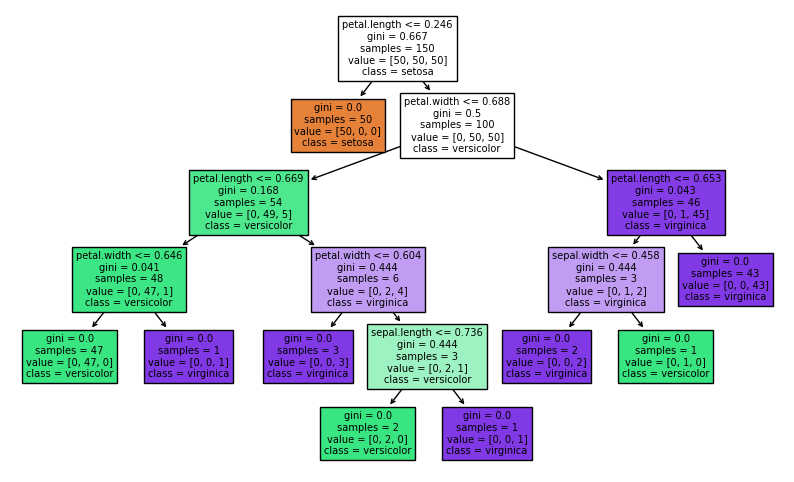

Accuracy: 1.0
Feature importances: [0.01333333 0.01333333 0.55072262 0.42261071]
Number of nodes: 17
Depth of the tree: 5
Number of leaves: 9


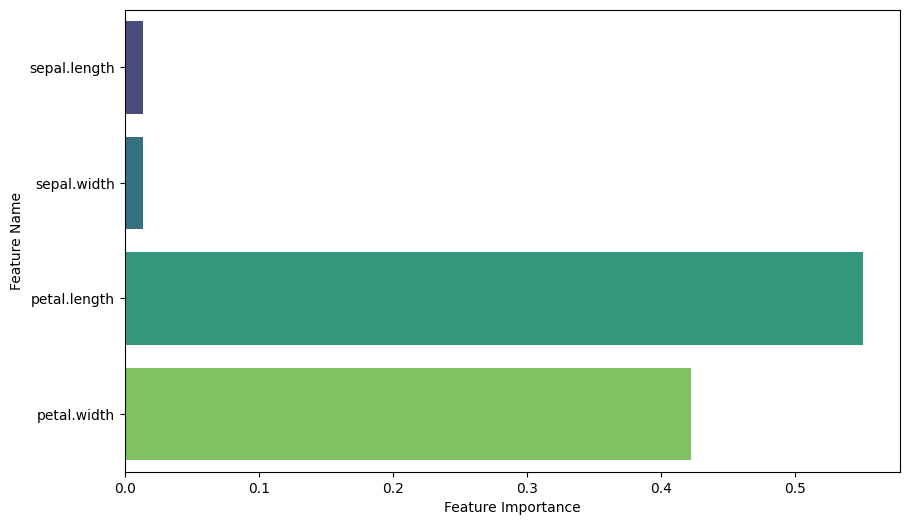

In [16]:
X = df_normalized.drop('class', axis=1)
y = df_normalized['class']

# Create the decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X, y)

# Plot the decision tree
plt.figure(figsize=fsize)
plot_tree(clf, feature_names=X.columns, class_names=class_names, filled=True)
plt.show()

print("Accuracy: " + str(clf.score(X, y)))
print("Feature importances: " + str(clf.feature_importances_))
print("Number of nodes: " + str(clf.tree_.node_count))
print("Depth of the tree: " + str(clf.tree_.max_depth))
print("Number of leaves: " + str(clf.get_n_leaves()))

# Visualize the feature importances

importances = clf.feature_importances_

plt.figure(figsize=fsize)

sns.barplot(x=importances, y=columns, palette="viridis", hue=columns)

plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')

plt.show()

### Support Vector Machine (SVM)

Testing various test split percentages, seed values, and kernel functions.

In [17]:
X = df_normalized[columns].values
y = df['class'].values

# Assuming df_normalized contains your features and labels
# Splitting the data into training and testing sets with various test sizes
test_sizes = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]  # List of test sizes to try

test_seeds = list(range(0, 101))  # List of random seeds to use

# Define a list of kernel types
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Initialize lists to store accuracies and number of support vectors for each test size
results = []

# Loop through each test size
for test_size in test_sizes:
    for seed in test_seeds:
        # Splitting the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        
        # Initialize lists to store results for current test size
        test_results = {'Test Size': test_size, 'Seed': seed}
        
        # Loop through each kernel type
        for kernel in kernels:
            # Train SVM with current kernel type
            svm_model = SVC(kernel=kernel)
            svm_model.fit(X_train, y_train)
            
            # Predictions on test set
            y_pred = svm_model.predict(X_test)
            
            # Calculate accuracy
            acc = accuracy_score(y_test, y_pred)
            test_results[f'{kernel}_Accuracy'] = acc
            
            # Number of support vectors
            n_support_vectors = len(svm_model.support_vectors_)
            test_results[f'{kernel}_Support_Vectors'] = n_support_vectors
        
        # Append results for current test size
        results.append(test_results)

results_df = pd.DataFrame(results)
pd.set_option('display.max_rows', None)  # Display all rows

# Find maximum and minimum values for accuracy and vector counts
max_accuracy = results_df[['linear_Accuracy', 'poly_Accuracy', 'rbf_Accuracy', 'sigmoid_Accuracy']].max().max()
max_accuracy_condition = results_df[['linear_Accuracy', 'poly_Accuracy', 'rbf_Accuracy', 'sigmoid_Accuracy']].max().idxmax()
max_accuracy_seed = results_df.loc[results_df[max_accuracy_condition] == max_accuracy, 'Seed'].values[0]
max_accuracy_test_size = results_df.loc[results_df[max_accuracy_condition] == max_accuracy, 'Test Size'].values[0]

min_accuracy = results_df[['linear_Accuracy', 'poly_Accuracy', 'rbf_Accuracy', 'sigmoid_Accuracy']].min().min()
min_accuracy_condition = results_df[['linear_Accuracy', 'poly_Accuracy', 'rbf_Accuracy', 'sigmoid_Accuracy']].min().idxmin()
min_accuracy_seed = results_df.loc[results_df[min_accuracy_condition] == min_accuracy, 'Seed'].values[0]
min_accuracy_test_size = results_df.loc[results_df[min_accuracy_condition] == min_accuracy, 'Test Size'].values[0]

max_vectors = results_df[['linear_Support_Vectors', 'poly_Support_Vectors', 'rbf_Support_Vectors', 'sigmoid_Support_Vectors']].max().max()
max_vectors_condition = results_df[['linear_Support_Vectors', 'poly_Support_Vectors', 'rbf_Support_Vectors', 'sigmoid_Support_Vectors']].max().idxmax()
max_vectors_seed = results_df.loc[results_df[max_vectors_condition] == max_vectors, 'Seed'].values[0]
max_vectors_test_size = results_df.loc[results_df[max_vectors_condition] == max_vectors, 'Test Size'].values[0]

min_vectors = results_df[['linear_Support_Vectors', 'poly_Support_Vectors', 'rbf_Support_Vectors', 'sigmoid_Support_Vectors']].min().min()
min_vectors_condition = results_df[['linear_Support_Vectors', 'poly_Support_Vectors', 'rbf_Support_Vectors', 'sigmoid_Support_Vectors']].min().idxmin()
min_vectors_seed = results_df.loc[results_df[min_vectors_condition] == min_vectors, 'Seed'].values[0]
min_vectors_test_size = results_df.loc[results_df[min_vectors_condition] == min_vectors, 'Test Size'].values[0]

# Calculate means for accuracy and vector counts
mean_accuracy = results_df[['linear_Accuracy', 'poly_Accuracy', 'rbf_Accuracy', 'sigmoid_Accuracy']].mean()
mean_vectors = results_df[['linear_Support_Vectors', 'poly_Support_Vectors', 'rbf_Support_Vectors', 'sigmoid_Support_Vectors']].mean()

# Tabulate the results
summary_df = pd.DataFrame({
    'Metric': ['Maximum Accuracy', 'Minimum Accuracy', 'Maximum Support Vectors', 'Minimum Support Vectors', 'Mean Accuracy', 'Mean Support Vectors'],
    'Value': [max_accuracy, min_accuracy, max_vectors, min_vectors, mean_accuracy.mean(), mean_vectors.mean()],
    'Condition': [f'{max_accuracy_condition}, Seed: {max_accuracy_seed}, Test Size: {max_accuracy_test_size}', 
                  f'{min_accuracy_condition}, Seed: {min_accuracy_seed}, Test Size: {min_accuracy_test_size}', 
                  f'{max_vectors_condition}, Seed: {max_vectors_seed}, Test Size: {max_vectors_test_size}', 
                  f'{min_vectors_condition}, Seed: {min_vectors_seed}, Test Size: {min_vectors_test_size}', '', '']
})

print(summary_df)

                    Metric       Value  \
0         Maximum Accuracy    1.000000   
1         Minimum Accuracy    0.000000   
2  Maximum Support Vectors  133.000000   
3  Minimum Support Vectors    2.000000   
4            Mean Accuracy    0.789026   
5     Mean Support Vectors   37.913757   

                                           Condition  
0          linear_Accuracy, Seed: 0, Test Size: 0.05  
1        sigmoid_Accuracy, Seed: 36, Test Size: 0.05  
2  sigmoid_Support_Vectors, Seed: 3, Test Size: 0.05  
3  linear_Support_Vectors, Seed: 11, Test Size: 0.95  
4                                                     
5                                                     


### Gaussian Naive Bayes

Confusion matrix and feature variance

Accuracy: 100.00%


<Figure size 1000x600 with 0 Axes>

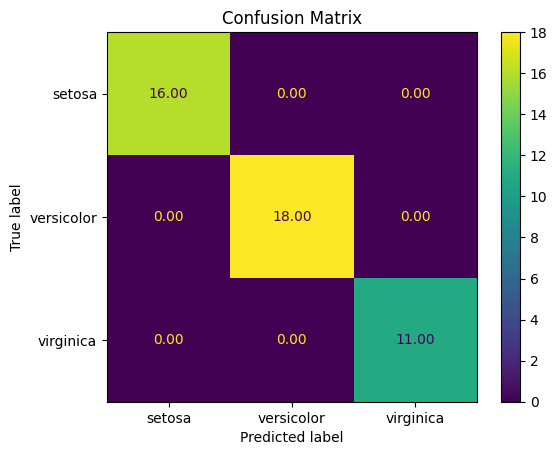

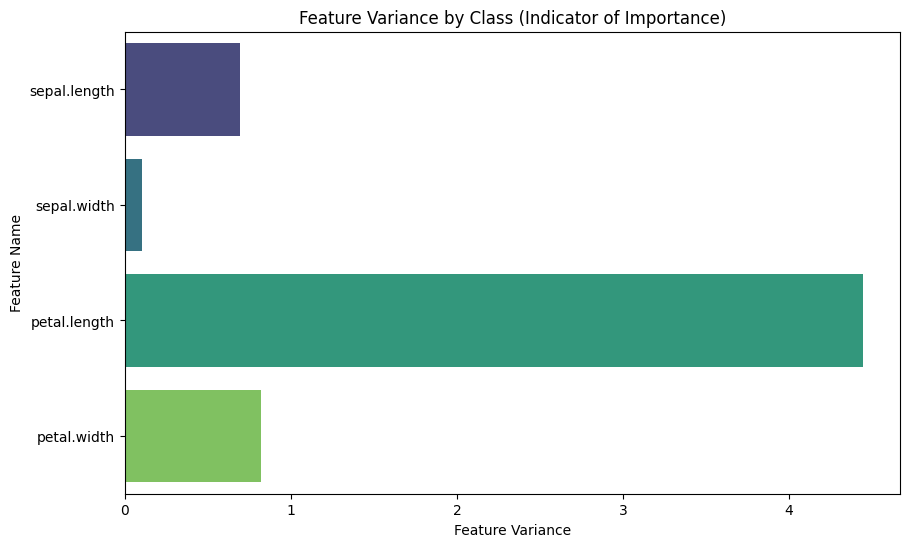

In [18]:
# Define features and labels
X = df.drop(columns=['class'])
y = df['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Create and train the Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predict the class labels
y_pred = gnb.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', values_format='.2f')
plt.title('Confusion Matrix')
plt.show()

# Since Gaussian Naive Bayes does not provide feature importances directly, we'll compute the variances of the features for each class.
feature_variances = pd.DataFrame(gnb.theta_, columns=X.columns, index=class_names).var()

# Plotting the feature variances as an indicator of importance
plt.figure(figsize=fsize)
sns.barplot(x=feature_variances.values, y=feature_variances.index, palette="viridis", hue=feature_variances.index)
plt.xlabel('Feature Variance')
plt.ylabel('Feature Name')
plt.title('Feature Variance by Class (Indicator of Importance)')
plt.show()
